In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from scipy.constants import mu_0

from desc.backend import jnp
from desc.compute.utils import surface_integrals
from desc.equilibrium import Equilibrium
from desc.grid import ConcentricGrid, LinearGrid
import desc.io
from desc.plotting import plot_1d
from desc.profiles import PowerSeriesProfile

np.set_printoptions(precision=3, floatmode="fixed")
jnp.set_printoptions(precision=3, floatmode="fixed")

DESC version 0.5.1+100.gc4b3314.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 11.36 GB available memory


## Visualizing different grids

In [3]:
rng = np.random.default_rng()
L = rng.integers(low=1, high=30)
M = rng.integers(low=1, high=30)
N = rng.integers(low=1, high=30)
NFP = rng.integers(low=1, high=30)
sym = True if rng.integers(2) > 0 else False
random_grid = ConcentricGrid(L=L, N=N, M=M, NFP=NFP, sym=sym)

In [4]:
def print_grid(grid, stop=None, quantity=None):
    """
    Parameters
    ----------
    grid
        Prints nodes and spacing.
    stop : int
        Max number of nodes to print. Defaults to entire grid.
    quantity : ndarray
        A quantity to print alongside the grid. i.e. data["iota"]
    """
    assert (
        len(grid.nodes) // grid.num_zeta
        == jnp.where(~jnp.isclose(grid.nodes[:, 2], 0))[0][0]
    )
    print(grid.L, grid.M, grid.N, grid.NFP, grid.sym, grid.node_pattern)
    print(grid.num_rho, grid.num_theta, grid.num_zeta)
    print("nodes", "             ", "spacing")
    if stop is None:
        stop = len(grid.nodes)
    if quantity is None:
        for i, e in enumerate(zip(grid.nodes, grid.spacing)):
            a, b = e
            print(a, b)
            if i > stop:
                break
    else:
        for i, e in enumerate(zip(grid.nodes, grid.spacing, quantity)):
            a, b, c = e
            print(a, b, c)
            if i > stop:
                break


print_grid(random_grid, stop=50)

7 25 3 1 True jacobi
4 66 7
nodes               spacing
[0.140 0.190 0.000] [0.346 0.711 1.117]
[0.140 0.762 0.000] [0.346 0.711 1.117]
[0.140 1.333 0.000] [0.346 0.711 1.117]
[0.140 1.904 0.000] [0.346 0.711 1.117]
[0.140 2.475 0.000] [0.346 0.711 1.117]
[0.140 3.046 0.000] [0.346 0.711 1.117]
[0.416 0.084 0.000] [0.363 0.313 1.117]
[0.416 0.335 0.000] [0.363 0.313 1.117]
[0.416 0.586 0.000] [0.363 0.313 1.117]
[0.416 0.838 0.000] [0.363 0.313 1.117]
[0.416 1.089 0.000] [0.363 0.313 1.117]
[0.416 1.340 0.000] [0.363 0.313 1.117]
[0.416 1.592 0.000] [0.363 0.313 1.117]
[0.416 1.843 0.000] [0.363 0.313 1.117]
[0.416 2.094 0.000] [0.363 0.313 1.117]
[0.416 2.346 0.000] [0.363 0.313 1.117]
[0.416 2.597 0.000] [0.363 0.313 1.117]
[0.416 2.848 0.000] [0.363 0.313 1.117]
[0.416 3.100 0.000] [0.363 0.313 1.117]
[0.723 0.052 0.000] [0.328 0.196 1.117]
[0.723 0.209 0.000] [0.328 0.196 1.117]
[0.723 0.367 0.000] [0.328 0.196 1.117]
[0.723 0.524 0.000] [0.328 0.196 1.117]
[0.723 0.681 0.000] [0.3

## Bulk flux surface averaging timeit

In [5]:
integrands = np.random.random_sample(size=len(random_grid.nodes))

In [6]:
%%timeit

integrals_1 = np.empty(random_grid.num_rho)
# collect collocation node indices for each rho surface
surfaces = dict()
for index, rho in enumerate(random_grid.nodes[:, 0]):
    surfaces.setdefault(rho, list()).append(index)
# integration over non-contiguous elements
ds = random_grid.spacing[:, 1:].prod(axis=1)
for i, surface_indices in enumerate(surfaces.values()):
    integrals_1[i] = (ds * integrands)[surface_indices].sum()

166 µs ± 5.28 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%%timeit

# TODO: are functions in compute.utils jit compiled by default, or should I add that?
# this used to be faster when in compute._core
integrals_2 = surface_integrals(random_grid, integrands)

2.39 ms ± 63.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
integrals_match_grid = surface_integrals(random_grid, integrands, match_grid=True)
print_grid(random_grid, stop=15, quantity=integrals_match_grid)

7 25 3 1 True jacobi
4 66 7
nodes               spacing
[0.140 0.190 0.000] [0.346 0.711 1.117] 18.12507625171116
[0.140 0.762 0.000] [0.346 0.711 1.117] 18.12507625171116
[0.140 1.333 0.000] [0.346 0.711 1.117] 18.12507625171116
[0.140 1.904 0.000] [0.346 0.711 1.117] 18.12507625171116
[0.140 2.475 0.000] [0.346 0.711 1.117] 18.12507625171116
[0.140 3.046 0.000] [0.346 0.711 1.117] 18.12507625171116
[0.416 0.084 0.000] [0.363 0.313 1.117] 13.406265768200756
[0.416 0.335 0.000] [0.363 0.313 1.117] 13.406265768200756
[0.416 0.586 0.000] [0.363 0.313 1.117] 13.406265768200756
[0.416 0.838 0.000] [0.363 0.313 1.117] 13.406265768200756
[0.416 1.089 0.000] [0.363 0.313 1.117] 13.406265768200756
[0.416 1.340 0.000] [0.363 0.313 1.117] 13.406265768200756
[0.416 1.592 0.000] [0.363 0.313 1.117] 13.406265768200756
[0.416 1.843 0.000] [0.363 0.313 1.117] 13.406265768200756
[0.416 2.094 0.000] [0.363 0.313 1.117] 13.406265768200756
[0.416 2.346 0.000] [0.363 0.313 1.117] 13.406265768200756
[0.416

In [9]:
def get_concentric_grid(eq):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.

    Returns
    -------
    ConcentricGrid
        Concentric grid used by the given equilibrium.
    """
    return ConcentricGrid(
        L=eq.L_grid,
        M=eq.M_grid,
        N=eq.N_grid,
        NFP=1,  # to avoid known grid bug
        sym=eq.sym,
        node_pattern=eq.node_pattern,
    )


def get_linear_grid(eq, rho):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    rho: ndarray
        Grid rhos.

    Returns
    -------
    LinearGrid
        LinearGrid grid for the given equilibrium.
    """
    return LinearGrid(
        M=max(1, eq.M_grid),
        N=max(1, eq.N_grid),
        NFP=1,  # to avoid known grid bug
        sym=eq.sym,
        rho=jnp.atleast_1d(rho),
    )


def get_vmec_plot(name, return_iota=True):
    """
    Parameters
    ----------
    name : str
        Name of the equilibrium.
    return_iota: bool
        Returns iota for the y value if True, else current.

    Returns
    -------
    rho : ndarray
        rho values. x-axis of plot.
    iota : ndarray
        iota. y-axis of plot.
    """
    f = Dataset("edu-vmec/input-current/wout_" + name + ".nc")
    iota = jnp.asarray(f.variables["iotaf"])
    rho = jnp.sqrt(f.variables["phi"] / np.array(f.variables["phi"])[-1])
    current = 2 * jnp.pi / mu_0 * jnp.array(f.variables["buco"])
    return rho, (iota if return_iota else current)


def plot(x, y, prepend_title):
    """
    Parameters
    ----------
    x : ndarray
        plot x-axis.
    y : ndarray
        plot y-axis. will make multiple plots if y.ndim > 1
    prepend_title : str
        string to prepend to plot title
    """
    dot_size = 5 if len(x) > 64 else 10
    y = np.atleast_2d(y)
    fig, ax = plt.subplots(ncols=y.shape[0], figsize=(y.shape[0] * 8, 5))
    ax = np.atleast_1d(ax)

    for i in range(y.shape[0]):
        append = " " + str(i) + " derivative wrt rho"
        ax[i].scatter(x, y[i, :], s=dot_size)
        ax[i].plot(x, y[i, :])
        ax[i].set(
            xlabel=r"$\rho$",
            ylabel="iota" + append,
            title=prepend_title + " iota" + append,
        )
        ax[i].grid()


def plot_overlay(x, y, prepend_title, x2, y2, prepend_title_2):
    """
    Parameters
    ----------
    x : ndarray
        plot x-axis.
    y : ndarray
        plot y-axis. will make multiple plots if y.ndim > 1
    prepend_title : str
        string to prepend to plot title
    """
    dot_size = 2 if len(x) > 128 else 5
    y = np.atleast_2d(y)
    y2 = np.atleast_2d(y2)
    fig, ax = plt.subplots()
    ax = np.atleast_1d(ax)

    for i in range(y.shape[0]):
        append = " " + str(i) + " derivative wrt rho"
        ax[i].scatter(x, y[i, :], s=dot_size, label=prepend_title)
        ax[i].plot(x, y[i, :])
        ax[i].scatter(x2, y2[i, :], s=dot_size, label=prepend_title_2)
        ax[i].plot(x2, y2[i, :])
        ax[i].set(
            xlabel=r"$\rho$",
            ylabel="iota" + append,
            title="iota" + append,
        )
        ax[i].grid()
    fig.legend()

7 25 3 1 True jacobi
4 66 7
nodes               spacing
[0.140 0.190 0.000] [0.346 0.711 1.117] -0.0
[0.140 0.762 0.000] [0.346 0.711 1.117] -0.0
[0.140 1.333 0.000] [0.346 0.711 1.117] -0.0
[0.140 1.904 0.000] [0.346 0.711 1.117] -0.0
[0.140 2.475 0.000] [0.346 0.711 1.117] -0.0
[0.140 3.046 0.000] [0.346 0.711 1.117] -0.0
[0.416 0.084 0.000] [0.363 0.313 1.117] -0.0
[0.416 0.335 0.000] [0.363 0.313 1.117] -0.0
[0.416 0.586 0.000] [0.363 0.313 1.117] -0.0
[0.416 0.838 0.000] [0.363 0.313 1.117] -0.0
[0.416 1.089 0.000] [0.363 0.313 1.117] -0.0
[0.416 1.340 0.000] [0.363 0.313 1.117] -0.0

7 25 3 1 True jacobi
4 66 7
nodes               spacing
[0.140 0.190 0.000] [0.346 0.711 1.117] -8.639400784391038
[0.140 0.762 0.000] [0.346 0.711 1.117] -8.639400784391038
[0.140 1.333 0.000] [0.346 0.711 1.117] -8.639400784391038
[0.140 1.904 0.000] [0.346 0.711 1.117] -8.639400784391038
[0.140 2.475 0.000] [0.346 0.711 1.117] -8.639400784391038
[0.140 3.046 0.000] [0.346 0.711 1.117] -8.632750525

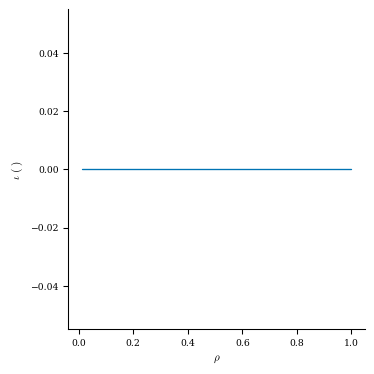

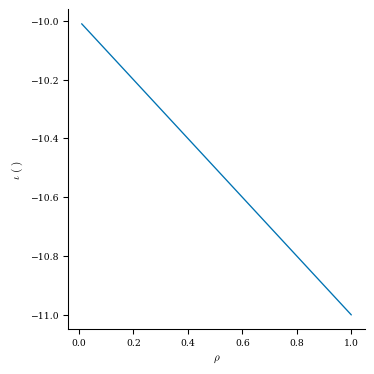

In [10]:
zero_current = PowerSeriesProfile(params=[0], modes=[0], grid=random_grid)
finite_current = PowerSeriesProfile(params=[1e7], modes=[2], grid=random_grid)
zero_current_torus = Equilibrium(current=zero_current)
finite_current_torus = Equilibrium(current=finite_current)

# linear grids for plotting
lin_grid_zero_torus = get_linear_grid(
    zero_current_torus, rho=random_grid.nodes[random_grid.unique_rho_indices, 0]
)
lin_grid_finite_torus = get_linear_grid(
    finite_current_torus, rho=random_grid.nodes[random_grid.unique_rho_indices, 0]
)

# plot_1d won't plot when linear grid (or any grid) is supplied ??
# does not plot the values in eq.compute(), probably because different grid
plot_1d(zero_current_torus, "iota")
print_grid(
    random_grid,
    stop=10,
    quantity=zero_current_torus.compute("iota", grid=lin_grid_zero_torus)["iota"],
)
print()
plot_1d(finite_current_torus, "iota")
print_grid(
    random_grid,
    stop=10,
    quantity=finite_current_torus.compute("iota", grid=lin_grid_finite_torus)["iota"],
)

Plots matched better when current was multiplied by mu_0/2pi instead of just mu_0. Below plots are equilibrium with just mu_0.

/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(


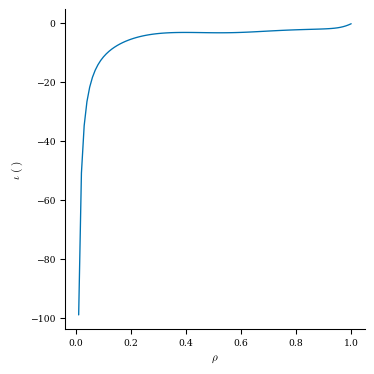

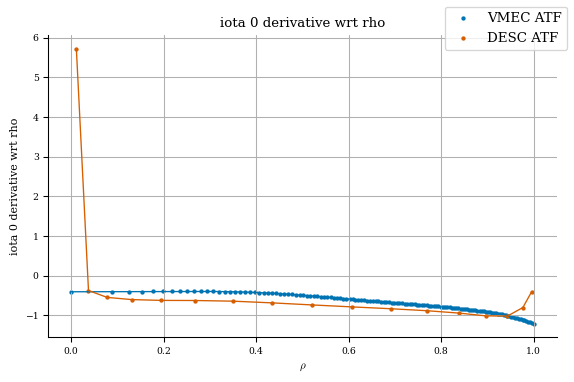

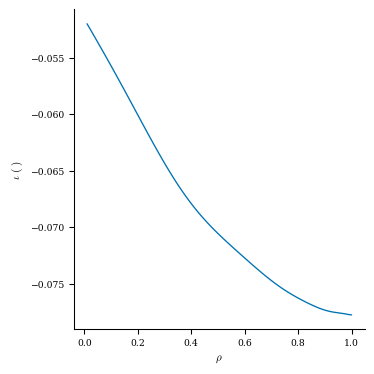

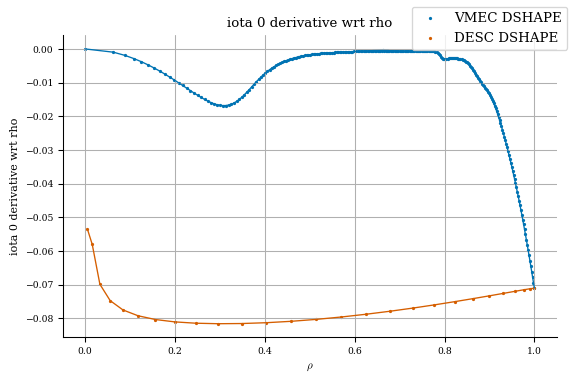

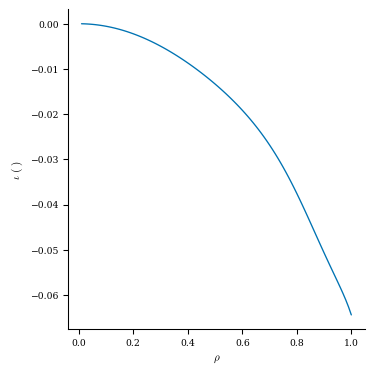

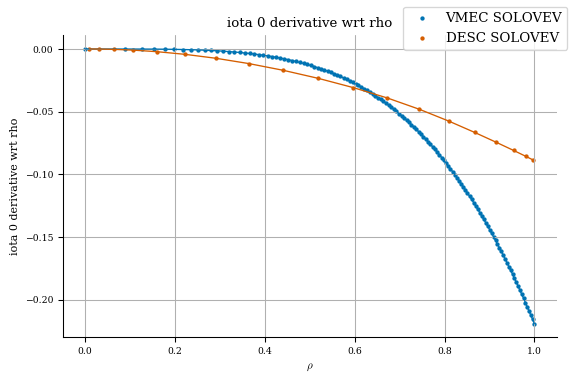

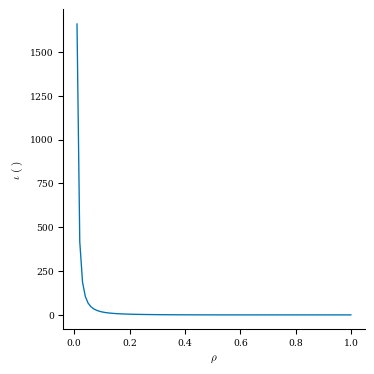

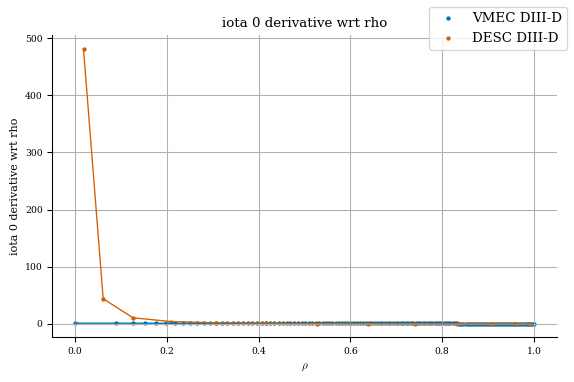

In [11]:
names = (
    "ATF",
    "DSHAPE",
    "SOLOVEV",
    "DIII-D",
)  # "HELIOTRON" not nested VMEC, "AXISYM" not nested DESC

stellarators = dict()
for name in names:
    eq = desc.io.load("../examples/DESC/input-current/" + name + "_output.h5")[-1]
    stellarators[name] = eq
    plot_1d(eq, "iota")

    rho, iota = get_vmec_plot(name)
    grid = get_concentric_grid(eq)
    iota_desc = eq.compute("iota", grid=grid)["iota"][grid.unique_rho_indices]
    plot_overlay(
        rho,
        iota,
        "VMEC " + name,
        grid.nodes[grid.unique_rho_indices, 0],
        iota_desc,
        "DESC " + name,
    )